# Methodology

1. **Create block splits:** This code performs a spatial analysis to determine how much of each Census block polygon falls within each TAZ (Traffic Analysis Zone), while filtering out tiny overlaps (slivers) and computing normalized area proportions.
2. Get Census Block Total Population (P3_001N)
3. Get ACS Block Group Total Population 18+ (P3_001N)
4. Get Block Group Percent of 18+ Population that is 65+

4) 17 and under population for portion of block in each TAZ is based proportionally to the total population in each split block
5) 65+ population for each split block is based on the Block Group %65+ from the 2020 ACS
6) Population by Age Group from "UDOT_BlockSplit" is summed by TAZ to determine overall TAZ age pct file in tab "SumBlock"
7) Data in "SumBlock" pivot table is copied to Export and appended with MedDist information from USTM TAZs.  This is exported to a tab in _TAZ_AgePct_Lookup_Source - 2022-04-05.xlsb
8) "CheckControl" tab scales 2020 estimates by County and compares to 2019 Population by Age Controls from "_ControlTotal_SE - Source - 2022-03-01.xlsx"


In [ ]:
# Import libraries
import geopandas as gpd
import pandas as pd
from census import Census
from us import states
import cenpy
import requests
import matplotlib

In [ ]:
census_year = 2020
acs_year = 2020
state_fips = 49 #Utah

BASE_URL_CENSUS = 'https://api.census.gov/data/2020/dec/pl'

In [ ]:
# read in taz and census block group geometries
blk_gdf = gpd.read_file("data/census/tl_2020_49_tabblock20/tl_2020_49_tabblock20.shp")
taz_gdf = gpd.read_file("data/USTMv4_20250729/USTMv4_20250729.shp")  # Must include CO_TAZID

In [134]:
# Read the Census API key from a text file
with open('ignore/census-key.txt', 'r') as f:
    CENSUS_API_KEY = f.read().strip()

from census import Census
c = Census(CENSUS_API_KEY)

In [132]:
# check if API working

from us import states

# Get total population (B01003_001E) for Utah (FIPS 49)
response = c.acs5.state(
    fields=('NAME', 'B01003_001E'),
    state_fips=states.UT.fips,
    year=acs_year
)

print(response)

[{'NAME': 'Utah', 'B01003_001E': 3151239.0, 'state': '49'}]


In [52]:
utah_counties = [
    {"name": "Beaver"     , "fips": "001"},
    {"name": "Box Elder"  , "fips": "003"},
    {"name": "Cache"      , "fips": "005"},
    {"name": "Carbon"     , "fips": "007"},
    {"name": "Daggett"    , "fips": "009"},
    {"name": "Davis"      , "fips": "011"},
    {"name": "Duchesne"   , "fips": "013"},
    {"name": "Emery"      , "fips": "015"},
    {"name": "Garfield"   , "fips": "017"},
    {"name": "Grand"      , "fips": "019"},
    {"name": "Iron"       , "fips": "021"},
    {"name": "Juab"       , "fips": "023"},
    {"name": "Kane"       , "fips": "025"},
    {"name": "Millard"    , "fips": "027"},
    {"name": "Morgan"     , "fips": "029"},
    {"name": "Piute"      , "fips": "031"},
    {"name": "Rich"       , "fips": "033"},
    {"name": "Salt Lake"  , "fips": "035"},
    {"name": "San Juan"   , "fips": "037"},
    {"name": "Sanpete"    , "fips": "039"},
    {"name": "Sevier"     , "fips": "041"},
    {"name": "Summit"     , "fips": "043"},
    {"name": "Tooele"     , "fips": "045"},
    {"name": "Uintah"     , "fips": "047"},
    {"name": "Utah"       , "fips": "049"},
    {"name": "Wasatch"    , "fips": "051"},
    {"name": "Washington" , "fips": "053"},
    {"name": "Wayne"      , "fips": "055"},
    {"name": "Weber"      , "fips": "057"},
]
county_fips_list = [c["fips"] for c in utah_counties]

# Create Block Splits

<Axes: >

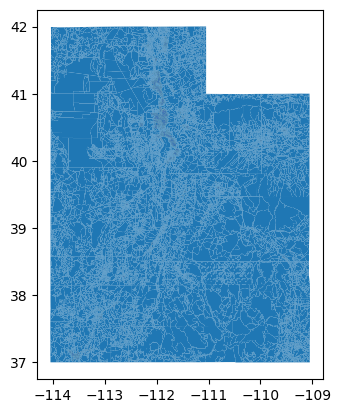

In [102]:
blk_gdf.plot()

<Axes: >

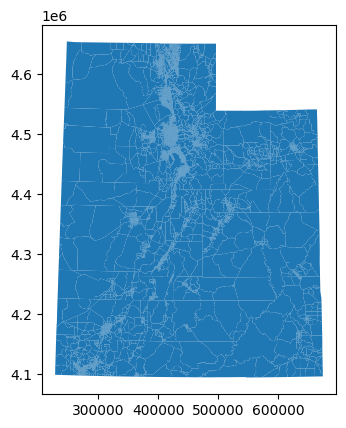

In [104]:
taz_gdf.plot()

In [147]:
import geopandas as gpd

# Match CRS
blk_crs_gdf = blk_gdf.to_crs(taz_gdf.crs).copy()

# Calculate original block area
blk_crs_gdf['blk_area'] = blk_crs_gdf.geometry.area

# Spatial intersection
intersect_gdf = gpd.overlay(blk_crs_gdf, taz_gdf[['CO_TAZID','SUBAREAID','geometry']], how='intersection')

# Calculate area of intersected pieces
intersect_gdf['intersect_area'] = intersect_gdf.geometry.area

# Merge original block area into intersected GeoDF
intersect_gdf = intersect_gdf.merge(
    blk_crs_gdf[['GEOID20', 'blk_area']], on='GEOID20'
)

# Filter out pieces <1% of original block
intersect_gdf = intersect_gdf[
    (intersect_gdf['intersect_area'] / intersect_gdf['blk_area_x']) >= 0.01
]

# Recalculate total area *remaining* per block (after filtering)
total_remaining_area = intersect_gdf.groupby('GEOID20')['intersect_area'].sum().reset_index()
total_remaining_area.rename(columns={'intersect_area': 'filtered_total_area'}, inplace=True)

# Merge back in
intersect_gdf = intersect_gdf.merge(total_remaining_area, on='GEOID20')

# Compute final ratio relative to total *remaining* block area
intersect_gdf['blk_area_ratio'] = intersect_gdf['intersect_area'] / intersect_gdf['filtered_total_area']

intersect_gdf['state' ] = intersect_gdf['GEOID20'].str.slice( 0,  2)
intersect_gdf['county'] = intersect_gdf['GEOID20'].str.slice( 2,  5)
intersect_gdf['tract' ] = intersect_gdf['GEOID20'].str.slice( 5, 11)
intersect_gdf['blk'   ] = intersect_gdf['GEOID20'].str.slice(11, 15)
intersect_gdf['blkgrp'] = intersect_gdf['GEOID20'].str.slice(11, 12)

# Final result (customize columns as needed)
block_splits_gdf = intersect_gdf[['state','county','tract','blk','blkgrp','CO_TAZID', 'blk_area_ratio', 'geometry']]
block_splits_gdf

,state,county,tract,blk,blkgrp,CO_TAZID,blk_area_ratio,geometry
0,49,047,940201,4135,4,47014.0,1.000000,"POLYGON ((599822.242 4468441.466, 599919.782 4..."
1,49,047,940201,4116,4,47014.0,1.000000,"POLYGON ((600447.484 4470941.559, 600451.73 44..."
2,49,047,940201,4038,4,47032.0,1.000000,"POLYGON ((593128.81 4486189.277, 593134.757 44..."
3,49,047,968201,2013,2,47096.0,1.000000,"POLYGON ((628910.942 4476057.924, 628900.443 4..."
4,49,035,113909,1031,1,350823.0,1.000000,"POLYGON ((409695.614 4495227.619, 409696.644 4..."
...,...,...,...,...,...,...,...,...
85957,49,005,000201,2047,2,50804.0,0.010603,"POLYGON ((429019.827 4629550.413, 429019.483 4..."
85958,49,005,000502,1020,1,50286.0,1.000000,"POLYGON ((430232.04 4623834.949, 430218.669 46..."
85959,49,043,964304,3004,3,43293.0,1.000000,"POLYGON ((451919.531 4510321.385, 451926.222 4..."
85960,49,005,000900,1000,1,50400.0,1.000000,"POLYGON ((431992.713 4620836.131, 431993.274 4..."


In [143]:
# check if block area ratios add back up to original number of blocks

num_blocks = blk_gdf['GEOID20'].nunique()

check = block_splits_gdf.groupby('GEOID20')['blk_area_ratio'].sum()

# Are all close to 1?
all_good = (check.round(5) == 1.0).sum()
print(f"{all_good} out of {num_blocks} blocks have area ratios summing to 1")

# How many are missing?
missing = num_blocks - check.shape[0]
print(f"{missing} blocks missing from result")


71207 out of 71207 blocks have area ratios summing to 1
0 blocks missing from result


# Get Census Block Population Data

In [148]:
# Variables: Total population, 18+ population
variables = ['P1_001N', 'P3_001N']

all_data = []

for county_fips in county_fips_list:
    params = {
        'get': ','.join(variables),
        'for': 'block:*',
        'in': f'state:{state_fips} county:{county_fips}',
        'key': CENSUS_API_KEY
    }
    try:
        response = requests.get(BASE_URL_CENSUS, params=params)
        response.raise_for_status()
        data = response.json()

        # First row is header
        columns = data[0]
        rows = data[1:]

        df = pd.DataFrame(rows, columns=columns)
        all_data.append(df)

        print(f"Downloaded data for county {county_fips}")
    except Exception as e:
        print(f"Error fetching county {county_fips}: {e}")

# Combine all
_df = pd.concat(all_data, ignore_index=True)

# Convert to numeric
for var in variables:
    _df[var] = pd.to_numeric(_df[var], errors='coerce')

_df.rename(columns={'block':'blk'}, inplace=True)
_df['blkgrp'] = _df['blk'].str[0]

_df.rename(columns={'P1_001N':'census_blk_poptotal','P3_001N':'census_blk_pop18plus'}, inplace = True)

_df = _df[['state','county','tract','blk','blkgrp','census_blk_poptotal','census_blk_pop18plus']]

census_blk_vars_df = _df
census_blk_vars_df

Downloaded data for county 001
Downloaded data for county 003
Downloaded data for county 005
Downloaded data for county 007
Downloaded data for county 009
Downloaded data for county 011
Downloaded data for county 013
Downloaded data for county 015
Downloaded data for county 017
Downloaded data for county 019
Downloaded data for county 021
Downloaded data for county 023
Downloaded data for county 025
Downloaded data for county 027
Downloaded data for county 029
Downloaded data for county 031
Downloaded data for county 033
Downloaded data for county 035
Downloaded data for county 037
Downloaded data for county 039
Downloaded data for county 041
Downloaded data for county 043
Downloaded data for county 045
Downloaded data for county 047
Downloaded data for county 049
Downloaded data for county 051
Downloaded data for county 053
Downloaded data for county 055
Downloaded data for county 057


,state,county,tract,blk,blkgrp,census_blk_poptotal,census_blk_pop18plus
0,49,001,100100,1000,1,0,0
1,49,001,100100,1001,1,0,0
2,49,001,100100,1003,1,0,0
3,49,001,100100,1004,1,0,0
4,49,001,100100,1006,1,0,0
...,...,...,...,...,...,...,...
71202,49,057,211202,3019,3,16,8
71203,49,057,211202,3030,3,0,0
71204,49,057,211202,1010,1,98,88
71205,49,057,211202,1011,1,30,28


# Get ACS Block Group Population Data

In [158]:
# Define age variables (ACS 5-year, table B01001)
# We'll get population counts by broad age bands from B01001
# Example: Under 18 = sum of B01001_003 to B01001_006 (male) + B01001_027 to B01001_030 (female)

age_vars = {
    'TotPop': 'B01001_001E',  # Total population

    # Males Under 18
    'Male_0_17': [
        'B01001_003E',  # Male: Under 5 years
        'B01001_004E',  # Male: 5 to 9 years
        'B01001_005E',  # Male: 10 to 14 years
        'B01001_006E'   # Male: 15 to 17 years
    ],

    # Females Under 18
    'Female_0_17': [
        'B01001_027E',  # Female: Under 5 years
        'B01001_028E',  # Female: 5 to 9 years
        'B01001_029E',  # Female: 10 to 14 years
        'B01001_030E'   # Female: 15 to 17 years
    ],

    # Males 65+
    'Male_65plus': [
        'B01001_020E',  # Male: 65 and 66 years
        'B01001_021E',  # Male: 67 to 69 years
        'B01001_022E',  # Male: 70 to 74 years
        'B01001_023E',  # Male: 75 to 79 years
        'B01001_024E',  # Male: 80 to 84 years
        'B01001_025E'   # Male: 85 years and over
    ],

    # Females 65+
    'Female_65plus': [
        'B01001_044E',  # Female: 65 and 66 years
        'B01001_045E',  # Female: 67 to 69 years
        'B01001_046E',  # Female: 70 to 74 years
        'B01001_047E',  # Female: 75 to 79 years
        'B01001_048E',  # Female: 80 to 84 years
        'B01001_049E'   # Female: 85 years and over
    ]
}


# Flatten all variables for query
flat_vars = [v for values in age_vars.values() if isinstance(values, list) for v in values] + [age_vars['TotPop']]

# Query block group data
data = c.acs5.state_county_blockgroup(
    fields=flat_vars,
    state_fips=state_fips,
    county_fips='*',
    blockgroup='*',
    year=acs_year
)

_df = pd.DataFrame(data)

# Convert variables to numeric
for col in flat_vars:
    _df[col] = pd.to_numeric(_df[col], errors='coerce')

_df.rename(columns={'block group':'blkgrp'}, inplace=True)

# Calculate age categories
_df['Pop_0to17'] = _df[age_vars['Male_0_17']].sum(axis=1) + _df[age_vars['Female_0_17']].sum(axis=1)
_df['Pop_65plus'] = _df[age_vars['Male_65plus']].sum(axis=1) + _df[age_vars['Female_65plus']].sum(axis=1)
_df['Pop_18to64'] = _df[age_vars['TotPop']] - _df['Pop_0to17'] - _df['Pop_65plus']

# Create GEOID for spatial join
_df['GEOID'] = _df['state'] + _df['county'] + _df['tract'] + _df['blkgrp']

_df['acs_blkgrp_pct65Plus'] = _df['Pop_65plus'] / (_df['Pop_0to17'] + _df['Pop_65plus'] + _df['Pop_18to64'])

_df = _df[['state','county','tract', 'blkgrp','acs_blkgrp_pct65Plus']]

_df = _df.sort_values(['state','county','tract', 'blkgrp'])

acs_blkgrp_vars_df = _df
acs_blkgrp_vars_df

,state,county,tract,blkgrp,acs_blkgrp_pct65Plus
90,49,001,100100,1,0.059553
1758,49,001,100100,2,0.207428
1759,49,001,100100,3,0.208219
91,49,001,100200,1,0.117647
1760,49,001,100200,2,0.124829
...,...,...,...,...,...
1652,49,057,211202,1,0.429229
282,49,057,211202,2,0.239525
1653,49,057,211202,3,0.191608
1654,49,057,211202,4,0.245518


# Join Data and Calculate

In [161]:
bs_blk_df = pd.merge(block_splits_gdf.drop(columns='geometry'), census_blk_vars_df, on=['state','county','tract','blk','blkgrp'], how='left')
bs_blk_df['census_blk_area_poptotal' ] = bs_blk_df['census_blk_poptotal' ] * bs_blk_df['blk_area_ratio']
bs_blk_df['census_blk_area_pop18plus'] = bs_blk_df['census_blk_pop18plus'] * bs_blk_df['blk_area_ratio']
bs_blk_df.drop(columns=['census_blk_poptotal','census_blk_pop18plus'], inplace=True)
bs_blk_blkgrp_df = pd.merge(bs_blk_df,acs_blkgrp_vars_df,on=['state','county','tract','blkgrp'])
bs_blk_blkgrp_df

,state,county,tract,blk,blkgrp,CO_TAZID,blk_area_ratio,census_blk_area_poptotal,census_blk_area_pop18plus,acs_blkgrp_pct65Plus
0,49,047,940201,4135,4,47014.0,1.000000,0.0,0.0,0.130689
1,49,047,940201,4116,4,47014.0,1.000000,1.0,0.0,0.130689
2,49,047,940201,4038,4,47032.0,1.000000,0.0,0.0,0.130689
3,49,047,968201,2013,2,47096.0,1.000000,39.0,26.0,0.162605
4,49,035,113909,1031,1,350823.0,1.000000,116.0,72.0,0.032445
...,...,...,...,...,...,...,...,...,...,...
85957,49,005,000201,2047,2,50804.0,0.010603,0.0,0.0,0.090909
85958,49,005,000502,1020,1,50286.0,1.000000,534.0,418.0,0.011503
85959,49,043,964304,3004,3,43293.0,1.000000,9.0,2.0,0.155696
85960,49,005,000900,1000,1,50400.0,1.000000,390.0,304.0,0.088803


In [162]:
bs_blk_blkgrp_df['blk_area_pop00to17'] = bs_blk_blkgrp_df['census_blk_area_poptotal'] - bs_blk_blkgrp_df['census_blk_area_pop18plus']
bs_blk_blkgrp_df['blk_area_pop65plus'] = bs_blk_blkgrp_df['census_blk_area_poptotal'] * bs_blk_blkgrp_df['acs_blkgrp_pct65Plus']
bs_blk_blkgrp_df['blk_area_pop18to64'] = bs_blk_blkgrp_df['census_blk_area_pop18plus'] * bs_blk_blkgrp_df['blk_area_pop65plus']
bs_blk_blkgrp_df

,state,county,tract,blk,blkgrp,CO_TAZID,blk_area_ratio,census_blk_area_poptotal,census_blk_area_pop18plus,acs_blkgrp_pct65Plus,blk_area_pop00to17,blk_area_pop65plus,blk_area_pop18to64
0,49,047,940201,4135,4,47014.0,1.000000,0.0,0.0,0.130689,0.0,0.000000,0.000000
1,49,047,940201,4116,4,47014.0,1.000000,1.0,0.0,0.130689,1.0,0.130689,0.000000
2,49,047,940201,4038,4,47032.0,1.000000,0.0,0.0,0.130689,0.0,0.000000,0.000000
3,49,047,968201,2013,2,47096.0,1.000000,39.0,26.0,0.162605,13.0,6.341604,164.881701
4,49,035,113909,1031,1,350823.0,1.000000,116.0,72.0,0.032445,44.0,3.763651,270.982854
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85957,49,005,000201,2047,2,50804.0,0.010603,0.0,0.0,0.090909,0.0,0.000000,0.000000
85958,49,005,000502,1020,1,50286.0,1.000000,534.0,418.0,0.011503,116.0,6.142718,2567.656073
85959,49,043,964304,3004,3,43293.0,1.000000,9.0,2.0,0.155696,7.0,1.401266,2.802532
85960,49,005,000900,1000,1,50400.0,1.000000,390.0,304.0,0.088803,86.0,34.633205,10528.494208
